# Data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

In [3]:
catalog = pd.read_csv('data/data_catalogue.csv')
data = pd.read_csv('data/data_arena_members.csv')

In [4]:
def plot_hist2d(x,
                y,
                title,
                xlabel,
                ylabel,
                ax,
                bins=(50,50),
                cmap=plt.cm.BuPu):
    ax.hist2d(x, y, bins=bins, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def price_ditributions(catalog,
                       price='creds'):
    if not price in ['creds', 'gold']:
        raise ValueError('Can display only creds and gold distibutions!')
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,30))
    for i, ax in enumerate(axs.flat):
        ax.set_title(f'Level {i + 1}')
        sns.distplot(catalog[catalog['item_level']==i+1]['item_price_credit' if price=='creds' else 'item_price_gold'].values,
                     kde=i!=0 and i!=9, bins=15, ax=ax)
    plt.show()
    
def get_regression_line(x,
                        y,
                        degree):
    params = np.polyfit(x, y, degree)
    poly = np.poly1d(params)
    x_grid = np.linspace(min(x), max(x), 100)
    y_grid = poly(x_grid)
    return x_grid, y_grid

def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[len(features)]),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    loss = tf.keras.losses.MSE

    model.compile(loss=loss,
                  optimizer=optimizer)
    return model

def plot_history(models):
    k = len(models)
    
    fig, axs = plt.subplots(nrows=(k+1)//2, ncols=2, figsize=(16,30))
    
    for i, ax in enumerate(axs.flat):
        if i >= k:
            break
        
        history = models[i][1]
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
    
        ax.set_title(f'Model {i+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        
        ax.plot(hist['epoch'], hist['loss'], label='Train loss')
        ax.plot(hist['epoch'], hist['val_loss'], label='Val loss')
        
        ax.set_ylim([0,1])
        ax.legend()

    plt.show()
    
def get_mean_mse(models):
    total_loss = 0
    for model in models:
        total_loss += model[2]
    return total_loss / len(models)

def get_best_model(models):
    min_loss, ind = float('inf'), -1
    for i, model in enumerate(models):
        if model[2] < min_loss:
            min_loss = model[2]
            ind = i
    return models[ind][0]

In [5]:
def compare_results(targets, y_limits, model_name):
    
    target = targets[0]
    predicted = targets[1]
    # Compare target and predicted values
    plt.figure(figsize=(10, 6));
    sns.regplot(x=target, y=predicted, marker="*", scatter_kws={"s": 80}, ci=68);
    plt.xlabel('Target price');
    plt.ylabel('Predicted price');
    plt.title('Predicted vs. target - ' + model_name)
    
    # Visualize prediction difference
    prediction_diff = target - predicted
    plt.figure(figsize=(10, 6));
    sns.scatterplot(np.arange(prediction_diff.shape[0]), prediction_diff, 
                    marker="*", s=150);
    plt.axhline(y=0, color='r', linestyle='-');
    plt.axhline(y=prediction_diff.mean(), color='m', linestyle='--');
    plt.ylim(y_limits[0], y_limits[1]);
    plt.xlabel('Target price');
    plt.ylabel('Target - Prediction');
    plt.title('diff(target, prediction) - ' + model_name)
    
    
def visualize_data(pca_data, targets, model_name, dr_type):
    
    # Visualize first PCs
    fig, axes = plt.subplots(1, 2, figsize=(18, 6));
    
    for idx, axis in enumerate(axes):
        sns.scatterplot(pca_data[:, 0], pca_data[:, 1],
                        marker="o", hue=targets[idx], s=100, ax=axis);
        axis.set_xlabel(dr_type + ' 1');
        axis.set_ylabel(dr_type + ' 2');
        axis.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False);
        if idx == 0:
            axis.set_title(dr_type + ' scores - target prices')
        else:
            axis.set_title(dr_type + ' scores - predicted prices, ' + model_name)
    
    
def perform_pca(data):
    # Scale data and perform PCA
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    pca_model = PCA(n_components=0.95)
    data_pca = pca_model.fit_transform(data_scaled)
    return data_pca

# Cleaning catalog

In [6]:
removed_tanks = pd.DataFrame()

masks = [
    ('cleaning by crew_size: 2 <= crew_size <= 6', \
    (catalog['crew_size'] >= 2) & (catalog['crew_size'] <= 6)),
    
    ('cleaning by 1 level: item_price_credit = item_price_gold = 0', \
    (catalog['item_level'] != 1) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] == 0))),
    
    ('cleaning by price: item_price_credit > 100 or item_price_gold > 100', \
    (catalog['item_level'] == 1) | \
    (((catalog['item_price_credit'] > 100) & (catalog['item_price_gold'] == 0)) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] > 100)))),
    
    ('custom cleaning by price 2 level: 2000 < item_price_credit < 20000', \
    (catalog['item_level'] != 2) | (catalog['item_price_gold'] != 0) | \
    (catalog['item_price_credit'] > 2000) & (catalog['item_price_credit'] < 20000)),
    
    ('custom cleaning by price 5 level: item_price_credit < 500000', \
    (catalog['item_level'] != 5) | \
    (catalog['item_price_gold'] != 0) | (catalog['item_price_credit'] < 500000))
]

for mask in masks:
    N = len(catalog)
    
    removed_tanks = pd.concat([removed_tanks, catalog.loc[~mask[1]]])
    catalog = catalog.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(catalog)} rows.')
    
catalog.index = np.arange(len(catalog))
removed_tanks.index = np.arange(len(removed_tanks))

print(f'\nTotally removed {len(removed_tanks)} rows.')

[CLEANING BY CREW_SIZE: 2 <= CREW_SIZE <= 6]: removed 7 rows.
[CLEANING BY 1 LEVEL: ITEM_PRICE_CREDIT = ITEM_PRICE_GOLD = 0]: removed 9 rows.
[CLEANING BY PRICE: ITEM_PRICE_CREDIT > 100 OR ITEM_PRICE_GOLD > 100]: removed 98 rows.
[CUSTOM CLEANING BY PRICE 2 LEVEL: 2000 < ITEM_PRICE_CREDIT < 20000]: removed 20 rows.
[CUSTOM CLEANING BY PRICE 5 LEVEL: ITEM_PRICE_CREDIT < 500000]: removed 1 rows.

Totally removed 135 rows.


In [7]:
classEncoder = LabelEncoder()

catalog['item_class'] = classEncoder.fit_transform(catalog['item_class'])
catalog

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,1,4,356700,0,5,4
1,17,4,373000,0,5,5
2,33,2,0,1500,5,5
3,49,4,0,7500,8,4
4,81,4,0,0,1,5
...,...,...,...,...,...,...
748,64817,3,0,3500,6,5
749,65041,1,0,0,1,6
750,65073,2,0,12250,8,4
751,65297,2,0,12500,8,5


In [8]:
print('Duplicates: ', catalog.duplicated().sum())
print('Missing values: ', catalog.isnull().sum())
print('Catalog shape: ', catalog.shape)

Duplicates:  0
Missing values:  item_cd              0
item_class           0
item_price_credit    0
item_price_gold      0
item_level           0
crew_size            0
dtype: int64
Catalog shape:  (753, 6)


In [9]:
s1 = set(removed_tanks['item_cd'])
s2 = set(data['vehicle_type_cd'])

removed_ids = s1.intersection(s2)
print(removed_ids)

{6225, 13889, 9297, 65281}


# Visualizing catalog

In [ ]:
creds_catalog = catalog[catalog['item_price_gold'] == 0]
gold_catalog = catalog[catalog['item_price_credit'] == 0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

degree = 3
prices = creds_catalog[['item_level', 'item_price_credit']].values

plot_hist2d(x=creds_catalog['item_level'],
            y=creds_catalog['item_price_credit'],
            title='Price credits distribution by level',
            xlabel='Level',
            ylabel='Price credits',
            ax=axs[0])
axs[0].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

degree = 3
prices = gold_catalog[['item_level', 'item_price_gold']].values

plot_hist2d(x=gold_catalog['item_level'],
            y=gold_catalog['item_price_gold'],
            title='Price gold distribution by level',
            xlabel='Level',
            ylabel='Price gold',
            ax=axs[1])
axs[1].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

plt.show()

In [ ]:
for feature in ['item_cd']:
    catalog[feature] = pd.Categorical(catalog[feature])

In [ ]:
sns.countplot(classEncoder.inverse_transform(catalog['item_class']));

In [ ]:
sns.countplot(catalog['item_level']);

In [ ]:
sns.countplot(catalog['crew_size']);

# Cleaning data

## Removing entries from "data" that corresponds to deleted tanks in "catalog"

In [10]:
mask = ~data['vehicle_type_cd'].isin(removed_ids)

removed_data = data.loc[~mask]
data = data.loc[mask]

data.reset_index(inplace=True, drop=True)
removed_data.reset_index(inplace=True, drop=True)

print('Removed number of rows: ', removed_data.shape[0])

Removed number of rows:  447


## Adding Categorical and DateTime features

In [11]:
# 'arena_id', 'account_db_id'
for feature in ['team_id', 'clan_db_id', 
               'prebattle_id', 'is_prebattle_creator', 'vehicle_type_cd']:
    data.loc[:, feature] = pd.Categorical(data[feature])
    
data.loc[:, 'dt'] = pd.to_datetime(data['dt'])

## Checking duplicates and missing values

In [12]:
print('Duplicates in "data": ', data.duplicated().sum());
print('Missing values in "data":\n', data.isnull().sum());

Duplicates in "data":  0
Missing values in "data":
 dt                          0
arena_id                    0
account_db_id               0
team_id                     0
clan_db_id                  0
prebattle_id                0
is_prebattle_creator        0
vehicle_type_cd             0
life_time_sec               0
shots                       0
hits                        0
he_hits                     0
pierced                     0
damage_dealt                0
damage_assisted_radio       0
damage_assisted_stun        0
damage_assisted_track       0
damage_received             0
shots_received              0
no_damage_shots_received    0
pierced_received            0
spotted                     0
damaged                     0
kills_made                  0
mileage_meter               0
remained_hp                 0
original_credits            0
original_xp                 0
premium_xp_factor           0
daily_xp_factor             0
battle_num                  0
damage_blocked_by_

## Checking outliers

In [ ]:
def calculate_z_score(data):
    return stats.zscore(data)

Something does not work here, check later

In [ ]:
# features = data.columns.values
# z_scores = np.zeros((data.shape[0], len(features)))
# z_score_threshold = 3

# feature_outliers = dict.fromkeys(features)

# # z-scores for old features
# for index, feature in enumerate(features):
#     feature_outliers = calculate_z_score(data[feature])
    
#     z_scores[:, index] = feature_outliers
#     feature_outliers[feature] = data[feature_outliers > z_score_threshold]
    
#     print(feature, feature_outliers[feature].shape[0])
    
#     # Plotting feature distribution
#     fig, ax = plt.subplots()
#     sns.distplot(data[feature], kde=False);
#     plt.axvline(feature_outliers[feature][feature].min(), ymin=0, ymax=ax.get_ylim()[1])

# Visualizing data

## dt

All battles took place in October 2018 (between October 1 and October 31)

In [ ]:
data['dt'].describe()

## arena_id

47.363 unique battles were held.

45.479 battles should be 15 vs. 15 players!

There were 30 players in most battles (30 -> 20 -> 14). 
However, in some battles, a number of players was either odd (19, 13) or 
strangely small (2, 4). Are those battles connected to special events?

In [ ]:
battles = data['arena_id'].value_counts()
battles

In [ ]:
battles.to_frame()['arena_id'].value_counts()

## account_db_id

367.685 unique players took part in battles.

In [ ]:
data['account_db_id'].value_counts()

## life_time_sec

In [ ]:
sns.distplot(data['life_time_sec']);

## remained_hp

In [ ]:
data_negative_hp = data[data['remained_hp'] < 0]
data_negative_hp.shape[0]

## damage_dealt (total, assisted, etc.)

There are 1549 rows in a dataset that correspond to so-called "away-from-keyboard" players

In [ ]:
data['total_damage_dealt'] = data['damage_dealt'] + data['damage_assisted_radio'] + \
    data['damage_assisted_stun'] + data['damage_assisted_track']

In [ ]:
data[(data['mileage_meter'] == 0) & (data['total_damage_dealt'] == 0)]

## original_credits, original_xp, booster_bonus_xp, booster_bonus_credits

There is one player with original_credits < 0.

In [ ]:
data[data['original_credits'] < 0]

# Create new features (normalized to time/etc) 

In [13]:
def normalize_feature(target_feature, norm_feature):
    if norm_feature != 0:
        return target_feature / norm_feature
    else:
        return 0
    
normalize_feature = np.vectorize(normalize_feature)

## Calculate additive features

In [14]:
data['total_damage_dealt'] = data['damage_dealt'] + data['damage_assisted_radio'] + \
    data['damage_assisted_stun'] + data['damage_assisted_track']

data['damage_shots_received'] = data['shots_received'] - data['no_damage_shots_received']

Turns out that data['damage_shots_received'] = data['pierced_received'], so this feature is not added.

## Normalize to time

In [15]:
target_features = ['shots', 'hits', 'he_hits', 'pierced', 'damage_dealt', 
                   'damage_assisted_track', 'damage_assisted_radio', 
                   'damage_assisted_stun', 'total_damage_dealt',
                   'damage_received', 'shots_received', 
                   'pierced_received', 'spotted', 
                   'damaged', 'kills_made', 'mileage_meter',
                   'damage_blocked_by_armor']
# target_features_normalized_sec = [feature + '_per_sec' for feature in target_features]
target_features_normalized_min = [feature + '_per_min' for feature in target_features]

In [16]:
data['life_time_min'] = data['life_time_sec'] / 60

for feature in target_features:
#     data[feature + '_per_sec'] = normalize_feature(data[feature], data['life_time_sec'])
    data[feature + '_per_min'] = normalize_feature(data[feature], data['life_time_min'])

## Normalize to hits, shots, etc.

In [17]:
features_normalized = ['hit_rate', 'he_hit_rate', 'pierced_rate',
                      'damage_per_pierced', 'pierced_received_per_shot', 
                      'damage_per_enemy', 'damage_per_enemy_per_min', 
                      'damage_blocked_per_hit', 'damage_blocked_received_ratio']
features_num = ['hits', 'he_hits', 'pierced', 'damage_received', 
               'pierced_received', 'total_damage_dealt', 'total_damage_dealt_per_min', 
               'damage_blocked_by_armor', 'damage_blocked_by_armor']
features_denom = ['shots', 'hits', 'hits', 'pierced_received', 'shots_received', 
                 'damaged', 'damaged', 'pierced_received', 'damage_received']

In [18]:
for new_feature, feature_num, feature_denom in zip(features_normalized,
                                                  features_num, features_denom):
    data[new_feature] = normalize_feature(data[feature_num], data[feature_denom])

## Compare distributions before and after normalization

### Normalized to life_time_min

In [ ]:
for feature in target_features:
    new_feature = feature + '_per_min'

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    axes[0].hist(data[feature], bins=40)
    axes[1].hist(data[new_feature], bins=40)
    
    axes[0].set_title(feature)
    axes[1].set_title(new_feature)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 18))
axes = axes.ravel()

for index, feature in enumerate(features_normalized):
    axes[index].hist(data[feature], bins=20);
    axes[index].set_title(feature)

## Calculate features that are based on winrates

### Add is_winner

In [19]:
def calc_winner(row):
    winner = 0
    if row['num_tanks_pos_1'] != 0 and row['num_tanks_pos_2'] == 0:
        winner = 1
    elif row['num_tanks_pos_2'] != 0 and row['num_tanks_pos_1'] == 0:
        winner = 2
    else:
        if row['mean_xp_1'] / row['mean_xp_2'] > 1.8:
            winner = 1
        elif row['mean_xp_2'] / row['mean_xp_1'] > 1.8:
            winner = 2
        else:
            winner = 0     
    return winner

In [20]:
data['is_alive'] = data['remained_hp'] > 0

# Getting data on full teams
warriors = data[data.groupby('arena_id')['account_db_id'].transform('count') == 30]
warriors.index = np.arange(len(warriors))
    
# Grouping teams by battles
battles = warriors.groupby(['arena_id', 'team_id'])
# Getting data on 15 vs. 15 battles
info_df = pd.DataFrame(index = [ind[0] for ind in battles.count().index][::2])
info_df['num_tanks_pos_1'] = battles['is_alive'].sum().iloc[::2].values
info_df['num_tanks_pos_2'] = battles['is_alive'].sum().iloc[1::2].values
info_df['mean_xp_1'] = battles['original_xp'].mean().iloc[::2].values
info_df['mean_xp_2'] = battles['original_xp'].mean().iloc[1::2].values
    
# Finding winning teams
info_df['winner_team_id'] = info_df.apply(calc_winner, axis=1)
info_df.reset_index(inplace=True)

# Merging winner_team_id with main dataset
data = data.merge(info_df[['index', 'winner_team_id']], 
                  how='left', left_on='arena_id', right_on='index')
data.drop(columns=['index'], inplace=True, axis=1)

data['is_winner'] = data['team_id'] == data['winner_team_id']

## Predict winrates based on original_xp

### Specify win_rates for players with >= 10 battles

In [21]:
players_for_train = data[data.groupby('account_db_id')
                         ['account_db_id'].transform('count') >= 10][['account_db_id',
                                                                      'original_xp', 
                                                                      'is_winner']]
players_for_train

,account_db_id,original_xp,is_winner
7,cyT1d14N1,2663,True
16,cdc4N7da7,386,False
21,cdyNTa2ac,2340,True
24,cydNTNdT4,1321,True
27,cdcy1dcaa,1398,True
...,...,...,...
1402948,c47NTTc22,1504,False
1402949,c47dyaNc7,1772,False
1402952,cd17T2Na7,1254,False
1402953,cac4aa12N,2532,False


In [22]:
players_for_train = players_for_train.groupby('account_db_id').agg({'original_xp' : ['mean', 'median'],
                                                                    'is_winner' : lambda g: sum(g) / len(g)})
players_for_train.columns = ['mean_original_xp', 'median_original_xp', 'player_winrate']
players_for_train.dropna(axis=0, inplace=True);

In [23]:
players_for_train

,mean_original_xp,median_original_xp,player_winrate
account_db_id,,,
c21114Naa,697.769231,597.0,0.538462
c2111Ncyd,1642.581395,1385.0,0.488372
c2111TTa7,231.400000,208.5,0.200000
c2111d217,1713.437500,1411.0,0.625000
c211212c4,830.400000,525.0,0.533333
...,...,...,...
cyyyyTcy4,511.913043,383.0,0.347826
cyyyya77a,1316.125000,867.0,0.312500
cyyyyd71y,1557.416667,1149.5,0.500000


In [24]:
mean_scaler = StandardScaler()
median_scaler = StandardScaler()

Xn_mean = mean_scaler.fit_transform(players_for_train[['mean_original_xp']])
Xn_median = median_scaler.fit_transform(players_for_train[['median_original_xp']])

Yn = players_for_train[['player_winrate']].values

Gradient Boosting model with mean

In [62]:
from sklearn.externals.six import StringIO

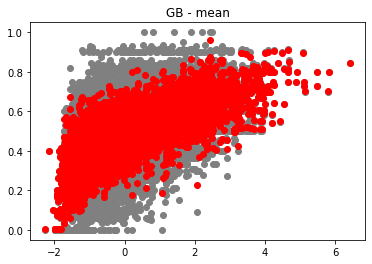

0.008190818839912704


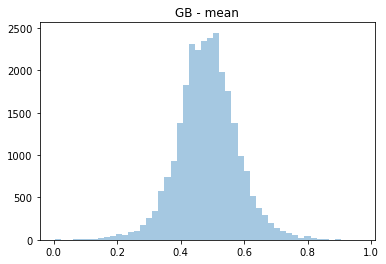

In [69]:
mean_model = GradientBoostingRegressor(n_estimators=200, max_depth=16)
fitted_mean_model = mean_model.fit(Xn_mean, Yn.reshape(len(Yn),))

preds_mean = mean_model.predict(Xn_mean)

plt.scatter(Xn_mean, Yn, color='gray')
plt.scatter(Xn_mean, preds_mean, color='red')
plt.title('GB - mean');
plt.show()

sns.distplot(preds_mean, kde=False, bins=50);
plt.title('GB - mean');

print(mean_squared_error(Yn, preds_mean));

Gradient Boosting with median

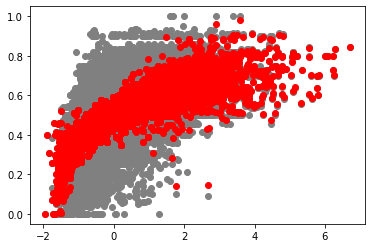

0.012190139189833906


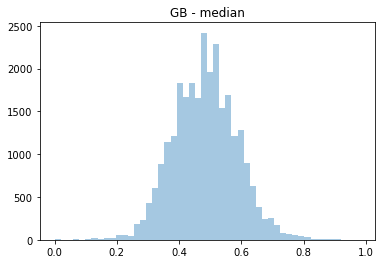

In [70]:
median_model = GradientBoostingRegressor(n_estimators=200, max_depth=16)
median_model.fit(Xn_median, Yn.reshape(len(Yn),))

preds_median = median_model.predict(Xn_median)

plt.scatter(Xn_median, Yn, color='gray')
plt.scatter(Xn_median, preds_median, color='red')
plt.show()

sns.distplot(preds_median, kde=False, bins=50);
plt.title('GB - median');

print(mean_squared_error(Yn, preds_median));

Gradient Boosting with GridSearch

In [72]:
data_types = ['mean_wr', 'median_wr']
X_train = [Xn_mean, Xn_median]
Y_train = Yn
Y_predicted = dict.fromkeys(data_types)
models = dict.fromkeys(data_types)

# Define a grid for GB parameters
gb_model = GradientBoostingRegressor()
gb_parameters = [
    {
        'n_estimators': [100, 200, 300, 400, 500], 
        'max_depth': [8, 16],
        'min_samples_split': [2, 4, 6, 8]
    }
]

for idx, data_type in enumerate(data_types):
    gc_model = GridSearchCV(estimator=gb_model, 
                            param_grid=gb_parameters,
                            cv=10,
                            refit=True,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            verbose=True)
    gc_model.fit(X_train[idx], Y_train.reshape(len(Y_train),))
    
    best_model = gc_model.best_estimator_
    model_params[data_type] = best_model
    print(data_type, gc_model.best_params_)
    
    # Use model with the best parameters to train on the whole dataset
    best_model.fit(X_train[idx], Y_train.reshape(len(Y_train),))        
    Y_pred = best_model.predict(X_train[idx])
    Y_predicted[data_type] = Y_pred
    
    print(data_type + ' model finished')

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 41.4min finished


mean_wr {'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 100}
mean_wr model finished
Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 37.6min finished


median_wr {'max_depth': 8, 'min_samples_split': 6, 'n_estimators': 100}
median_wr model finished


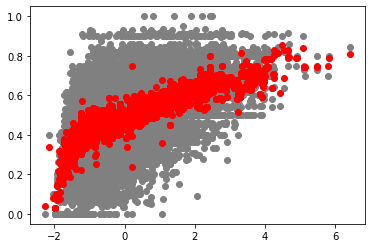

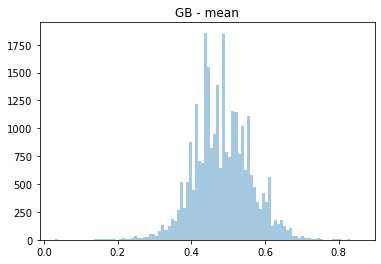

In [79]:
mean_gb_model = model_params['mean_wr']
mean_gb_model.fit(Xn_mean, Yn.reshape(len(Y_train),))
mean_predictions = mean_gb_model.predict(Xn_mean)

plt.scatter(Xn_mean, Yn, color='gray')
plt.scatter(Xn_mean, mean_predictions, color='red')
plt.show();

sns.distplot(mean_predictions, kde=False, bins=100);
plt.title('GB - mean');

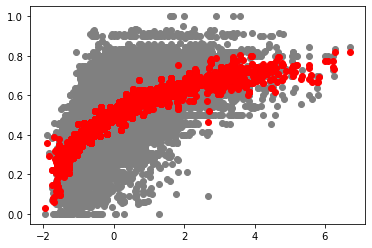

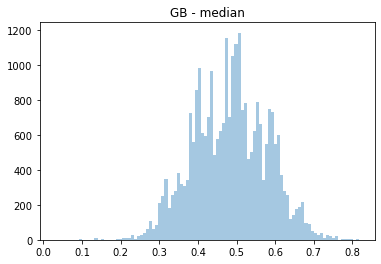

In [80]:
median_gb_model = model_params['median_wr']
median_gb_model.fit(Xn_median, Yn.reshape(len(Y_train),))
median_predictions = median_gb_model.predict(Xn_median)

plt.scatter(Xn_median, Yn, color='gray')
plt.scatter(Xn_median, median_predictions, color='red')
plt.show();

sns.distplot(median_predictions, kde=False, bins=100);
plt.title('GB - median');

### Predict win_rates for players with < 10 battles

In [55]:
players_for_test = data[data.groupby('account_db_id')
                        ['account_db_id'].transform('count') < 10][['account_db_id',
                                                                    'original_xp', 
                                                                    'is_winner']]
players_for_test = players_for_test.groupby('account_db_id').agg({
    'original_xp' : ['mean', 'median'],
    'is_winner' : lambda g: sum(g) / len(g)})
players_for_test.columns = ['mean_original_xp', 'median_original_xp', 'player_winrate']
players_for_test.dropna(axis=0, inplace=True)
players_for_test

,mean_original_xp,median_original_xp,player_winrate
account_db_id,,,
c2111224a,828.000000,828.0,0.00
c211122N4,797.000000,797.0,0.00
c21112TT1,424.750000,267.0,0.25
c21112aa2,1943.000000,1943.0,1.00
c21112yNT,755.000000,755.0,1.00
...,...,...,...
cyyyyyT74,1019.333333,797.5,0.50
cyyyyya7c,1894.250000,1379.5,0.50
cyyyyyd1a,221.000000,221.0,0.00


In [81]:
# Predict using mean values
Xn_mean_test = mean_scaler.transform(players_for_test[['mean_original_xp']])
Yn_mean_predicted = mean_gb_model.predict(Xn_mean_test)

# Predict using median values
Xn_median_test = median_scaler.transform(players_for_test[['median_original_xp']])
Yn_median_predicted = median_gb_model.predict(Xn_median_test)

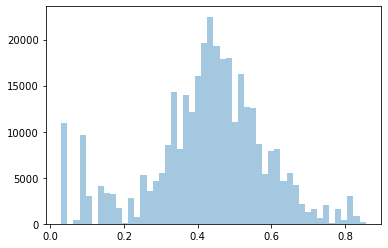

In [82]:
sns.distplot(Yn_mean_predicted, kde=False, bins=50);

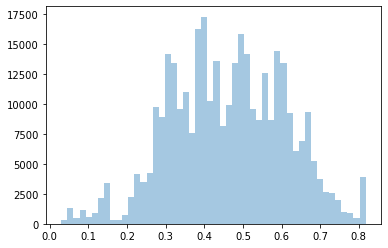

In [83]:
sns.distplot(Yn_median_predicted, kde=False, bins=50);

Compare results from learning on mean and median values

In [84]:
players_for_train['player_winrate_mean'] = preds_mean
players_for_test['player_winrate_mean'] = Yn_mean_predicted

players_for_train['player_winrate_median'] = preds_median
players_for_test['player_winrate_median'] = Yn_median_predicted

In [85]:
players_data = pd.concat([players_for_train, players_for_test])
data = data.merge(players_data[['player_winrate_mean', 
                                'player_winrate_median']], how='left', on='account_db_id')

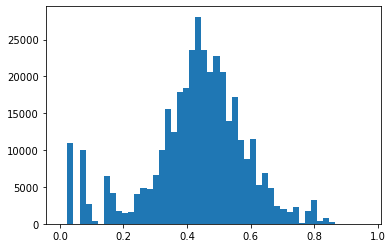

In [86]:
plt.hist(players_data['player_winrate_mean'], bins=50)
plt.show();

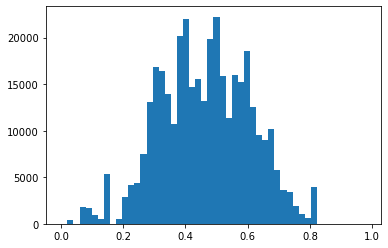

In [87]:
plt.hist(players_data['player_winrate_median'], bins=50)
plt.show();

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1402958 entries, 0 to 1402957
Data columns (total 67 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   dt                               1402958 non-null  datetime64[ns]
 1   arena_id                         1402958 non-null  object        
 2   account_db_id                    1402958 non-null  object        
 3   team_id                          1402958 non-null  category      
 4   clan_db_id                       1402958 non-null  category      
 5   prebattle_id                     1402958 non-null  category      
 6   is_prebattle_creator             1402958 non-null  category      
 7   vehicle_type_cd                  1402958 non-null  category      
 8   life_time_sec                    1402958 non-null  int64         
 9   shots                            1402958 non-null  int64         
 10  hits                          

Check what should be the minimum number of battles for every player so that there are no outliers in the win_rate distribution

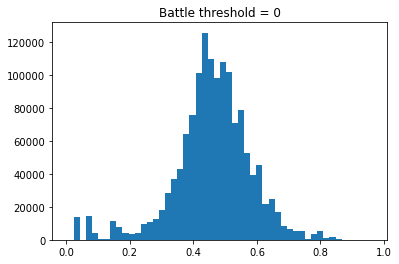

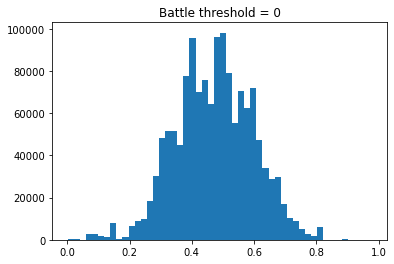

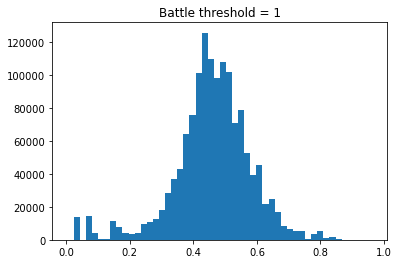

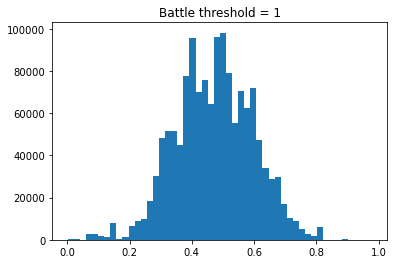

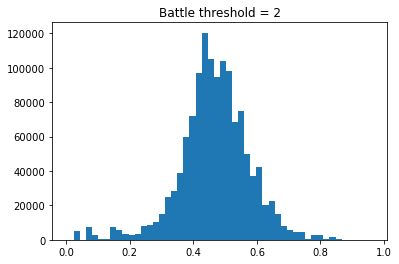

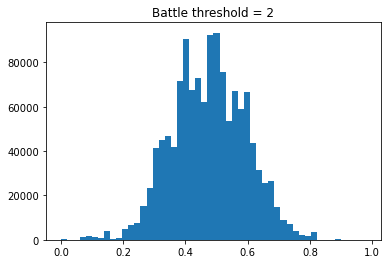

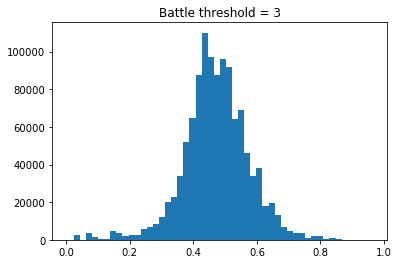

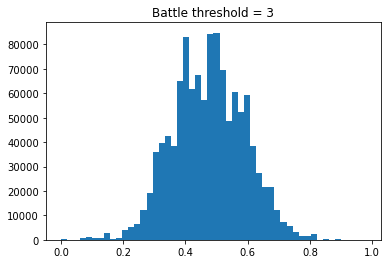

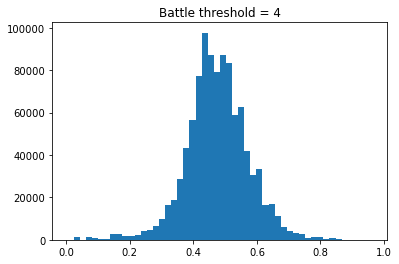

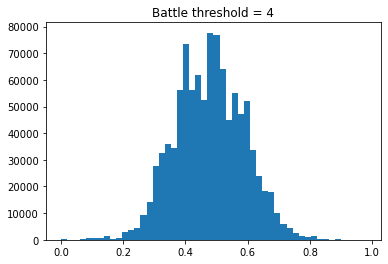

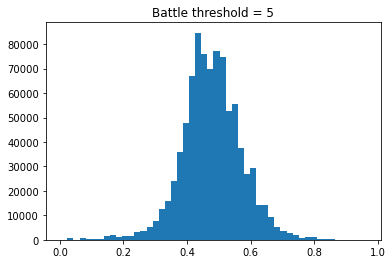

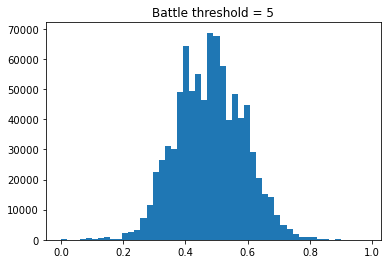

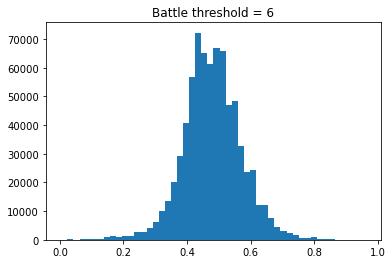

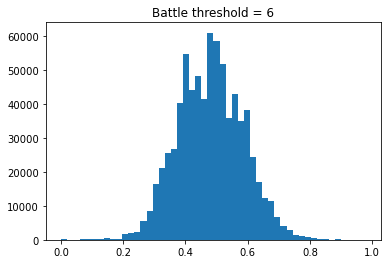

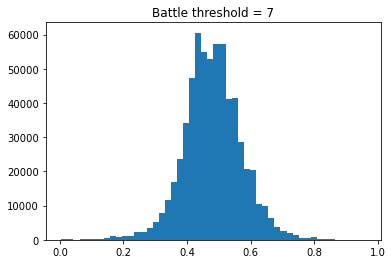

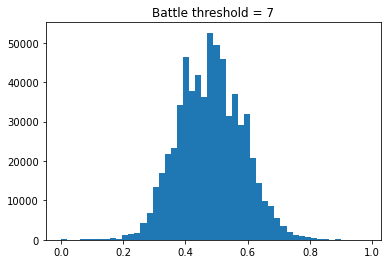

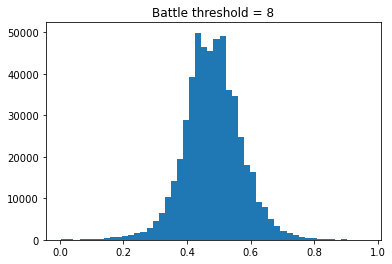

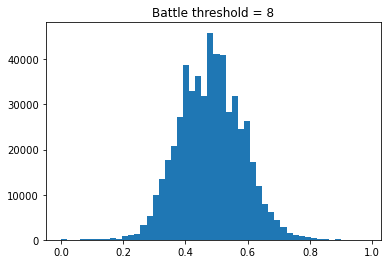

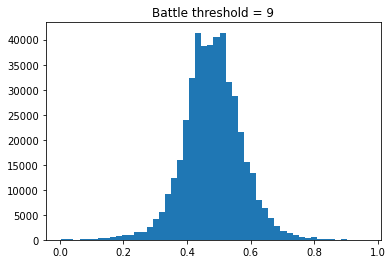

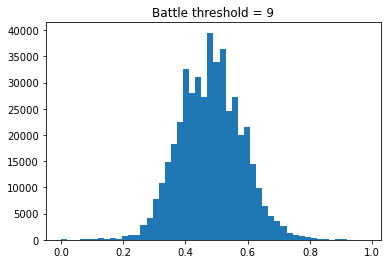

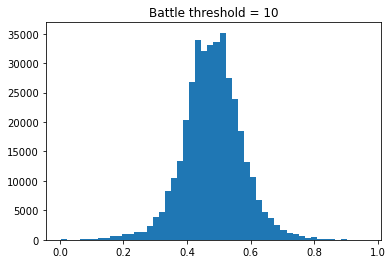

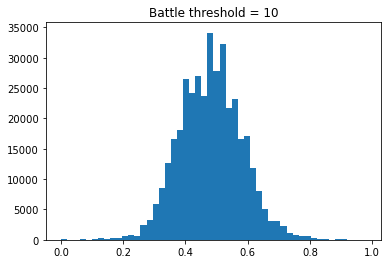

In [93]:
battle_thresholds = np.arange(11)

for battle_threshold in battle_thresholds:
    new_mean_data = data[data.groupby('account_db_id')
                         ['account_db_id'].
                         transform('count') >= battle_threshold]['player_winrate_mean']
    plt.hist(new_mean_data, bins=50);
    plt.title('Battle threshold = ' + str(battle_threshold));
    plt.show();

    new_data_median = data[data.groupby('account_db_id')
                           ['account_db_id'].
                           transform('count') >= battle_threshold]['player_winrate_median']
    plt.hist(new_data_median, bins=50);
    plt.title('Battle threshold = ' + str(battle_threshold));
    plt.show();

## Calculate tank win_rates

In [90]:
data = data[data.groupby('vehicle_type_cd')['vehicle_type_cd'].transform('count') >= 100]

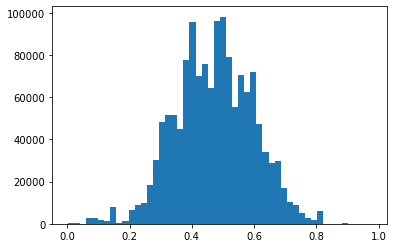

In [91]:
plt.hist(data['player_winrate_median'], bins=50)
plt.show();

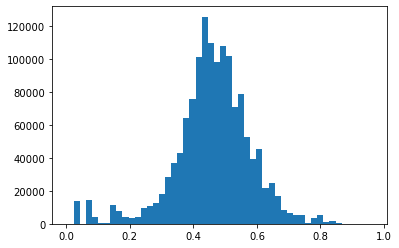

In [92]:
plt.hist(data['player_winrate_mean'], bins=50)
plt.show();

In [ ]:
tanks_data = data.groupby('vehicle_type_cd')[['original_xp',
                                              'is_winner']].agg({'original_xp' : ['mean', 'median'],
                                                                 'is_winner' : lambda g: sum(g) / len(g)})
tanks_data.columns = ['mean_original_xp', 'median_original_xp', 'tank_winrate']
tanks_data.dropna(axis=0, inplace=True)
tanks_data

In [ ]:
plt.hist(tanks_data['tank_winrate'], bins=50)
plt.show();

## Create new features (normalized to win_rate)

In [ ]:
normed_win_rate = 1 - data['player_winrate_median']
normed_win_rate

In [ ]:
data.info()

In [ ]:
data.loc[:, 'normed_damage_dealt'] = normed_win_rate * data['damage_dealt']
data.loc[:, 'normed_damage_assisted_stun'] = normed_win_rate * data['damage_assisted_stun']
data.loc[:, 'normed_damage_assisted_track'] = normed_win_rate * data['damage_assisted_track']
data.loc[:, 'normed_damage_blocked_by_armor'] = normed_win_rate * data['damage_blocked_by_armor']

# Additional features
# data['normed_damage_assisted_radio'] = normed_win_rate * data['damage_assisted_radio']
# data['normed_hits_per_min'] = normed_win_rate * data['hits_per_min']

In [ ]:
sns.distplot(data['damage_dealt'], kde=False, bins=40);
sns.distplot(data['normed_damage_dealt'], kde=False, bins=40);

In [ ]:
tanks_catalog = catalog.merge(tanks_data, how='left', left_on='item_cd', right_on=tanks_data.index)
tanks_catalog.dropna(axis=0, inplace=True)

In [ ]:
tanks_catalog

In [ ]:
data = data.merge(tanks_catalog, how='left', left_on='vehicle_type_cd', right_on='item_cd')
data.drop(['item_cd'], axis=1, inplace=True)

In [ ]:
dataset = data[['vehicle_type_cd', 'item_class', 'item_level', 'tank_winrate',
                'normed_damage_dealt', 'normed_damage_assisted_track', 
                'normed_damage_blocked_by_armor',
                'item_price_credit', 'item_price_gold']]
dataset

In [ ]:
new_data = data[data.groupby('account_db_id')['vehicle_type_cd'].transform('count') >= 10]
new_data

In [ ]:
new_data[(new_data['item_price_credit'] == 0) &
         (new_data['item_price_gold'] != 0)]['vehicle_type_cd'].nunique()

# Removing redundant features and outlier rows

## Redundant features

In [ ]:
redundant_features = ['premium_xp_factor', 'daily_xp_factor', 'is_prebattle_creator']
data.drop(redundant_features, axis=1, inplace=True)

In [ ]:
data.info()

In [ ]:
new_dataset.drop('Unnamed: 0', axis=1, inplace=True)

## Outliers

In [ ]:
# Removing "away-from-keyboard" players
afk_players = (data['mileage_meter'] == 0) & (data['total_damage_dealt'] == 0)
data = data.loc[~afk_players]
data.reset_index(inplace=True, drop=True)

# Preparing data for regression

## Creating features and targets

In [ ]:
regression_dataset = dataset.groupby('vehicle_type_cd').mean()

## Regression model (Egor)

In [ ]:
res_data = joined_data.groupby('vehicle_type_cd').mean().reset_index()
res_data = res_data[res_data['vehicle_type_cd'] != 9217]

features = ['item_level', 'item_class', 'damage_dealt', 'original_xp', 'original_credits', 'kills_made', 'damage_assisted_stun', 'he_hits', 'crew_size', 'hits', 'booster_bonus_credits']
target_credit = ['item_price_credit']
target_gold = ['item_price_gold']

credit_dataset = res_data[res_data['item_price_credit'] != 0][features + target_credit]
gold_dataset = res_data[res_data['item_price_gold'] != 0][features + target_gold]

gold_dataset

In [ ]:
credit_scaler = StandardScaler()
gold_scaler = StandardScaler()

normed_credit_dataset = pd.DataFrame(credit_scaler.fit_transform(credit_dataset), columns=[features + target_credit])
normed_gold_dataset = pd.DataFrame(gold_scaler.fit_transform(gold_dataset), columns=[features + target_gold])

normed_gold_dataset

In [ ]:
train_data, train_labels = np.array(normed_gold_dataset[features]), np.array(normed_gold_dataset[target_gold])

In [ ]:
k = 10
epochs = 100

models = []
for train_index, test_index in KFold(n_splits=k).split(train_data):
    x_train, y_train = train_data[train_index], train_labels[train_index]
    x_test, y_test = train_data[test_index], train_labels[test_index]
    
    model = build_model()
    history = model.fit(x_train, y_train, 
                        validation_data=(x_test, y_test),
                        epochs=epochs, shuffle=True, verbose=0)
    loss = model.evaluate(x_test, y_test)
    models.append((model, history, loss))

In [ ]:
plot_history(models)

In [ ]:
mean_mse = get_mean_mse(models)
mean_mse

In [ ]:
#'item_level', 'item_class' 'damage_dealt', 'original_xp', 'original_credits', 'kills_made', 'damage_assisted_stun', 'he_hits', 'crew_size', 'hits', 'booster_bonus_credits'

tank_params = [[8, 2, 994.758446, 1051.125426, 41486.045662, 0.614389, 0.0, 0.054945, 4.0, 5.207303, 2978.862081, 5]]

best_model = get_best_model(models)

x = gold_scaler.transform(tank_params)[:,:len(tank_params[0])-1]
test_predictions = best_model.predict(x)
xx = np.concatenate((x[0], test_predictions[0]))
gold_scaler.inverse_transform(xx)[-1]

In [ ]:
res_data[res_data['vehicle_type_cd'] == 9217][features]

## Regression models (Dasha)

## Create different models

In [ ]:
regression_dataset

In [ ]:
key_tank_id = 9217

regression_gold_dataset = regression_dataset[regression_dataset['item_price_gold'] > 0]

regression_gold_target = regression_gold_dataset['item_price_gold']
regression_gold_features = regression_gold_dataset.drop(['item_price_gold', 'item_price_credit'], axis=1)

# Select only data that corresponds to tank_id = 9217
key_tank_features = regression_gold_features[regression_gold_features.index == 
                                            key_tank_id]
key_tank_target = regression_gold_target[regression_gold_target.index == 
                                          key_tank_id]
# Remove this selection from the regression dataset
regression_features = regression_gold_features[regression_gold_features.index != 
                                               key_tank_id]
regression_target = regression_gold_target[regression_gold_target.index != 
                                           key_tank_id]

Introducing different regression models

In [ ]:
models = [RandomForestRegressor(), 
          GradientBoostingRegressor(),
          SVR(),
          SVR(),
          SVR()]

parameters = [
    {'n_estimators': [10, 50, 100, 500, 1000], 'max_depth': [2, 4, 6, 8, 10]},
    {'n_estimators': [10, 50, 100, 500, 1000], 'max_depth': [2, 4, 6, 8, 10]},
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 0.00001], 
     'kernel': ['rbf']},
    {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 0.00001], 
     'degree': [2, 3], 'coef0': [0, 1, 10, 100], 'kernel': ['poly']}
 ]

model_names = ['RandomForest', 'GradientBoost', 'SVM_linear', 'SVM_rbf', 'SVM_poly']

In [ ]:
is_target_scaled=True
is_pca_used=True

scores = ['MSE', 'RMSE', 'MAE']
regression_scores = np.zeros((len(models), len(scores)))

# Starting regression analysis
x_train = regression_features
y_train = regression_target
x_test = key_tank_features
y_test = key_tank_target

scaler = StandardScaler()
# Scaling features
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

if is_target_scaled:
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).ravel()
else:
    y_train_scaled = y_train
    y_test_scaled = y_test

# Removing collinearity between features
if is_pca_used:
    pca_model = PCA(n_components=0.95)
    x_train_pca = pca_model.fit_transform(x_train_scaled)
    x_test_pca = pca_model.transform(x_test_scaled)
else:
    x_train_pca = x_train_scaled
    x_test_pca = x_test_scaled
    
results = y_test_scaled.reshape(-1, 1)
for idx, model in enumerate(models):
    gc_model = GridSearchCV(estimator=model, 
                            param_grid=parameters[idx],
                            cv=10,
                            refit=True,
                            scoring='neg_mean_squared_error',
                            iid=False)
    gc_model.fit(x_train_pca, y_train_scaled)
    
    best_model = gc_model.best_estimator_
    print(model_names[idx], gc_model.best_params_)
    
    # Use model with the best parameters to train on the whole dataset
    best_model.fit(x_train_pca, y_train_scaled)        
    y_predicted = best_model.predict(x_test_pca)
        
    # Saving prediction results
    if is_target_scaled:
        results = np.hstack((results, scaler.inverse_transform(y_predicted).reshape(-1, 1)))
    else:
        results = np.hstack((results, y_predicted.reshape(-1, 1)))
    
    # Saving accuracy scores
    regression_scores[idx, 0] = mean_squared_error(y_test_scaled, y_predicted)
    regression_scores[idx, 1] = np.sqrt(mean_squared_error(y_test_scaled, y_predicted))
    regression_scores[idx, 2] = mean_absolute_error(y_test_scaled, y_predicted)
    
# Saving prediction results
regression_results = pd.DataFrame(data=results, index=x_test.index.values,
                                  columns=['y'] + model_names)
regression_scores = pd.DataFrame(data=regression_scores, index=model_names,
                                 columns=scores)

In [ ]:
regression_results

In [ ]:
regression_scores

Visualize best predictions

In [ ]:
for model in model_names:
    best_prediction = mse_scores[model].idxmin()

    targets = [regression_results[best_prediction]['y'],
               regression_results[best_prediction][model]]

    compare_results(targets, [-6_000, 6_000], model)
    
    # Perform PCA and visualize results
    items = regression_features.loc[regression_results[best_prediction][model].index]
    pca_items = perform_pca(items)

    visualize_data(pca_items, targets, model, dr_type='PCA')
    
    # Perform TSNE and visualize results
    tsne_items = TSNE(n_components=2, perplexity=5, learning_rate=10, init='pca').fit_transform(pca_items)
    
    visualize_data(tsne_items, targets, model, dr_type='t-SNE')

## Check battle levels

In [ ]:
# Create a dataframe with 
battle_players = full_battles_data.groupby('arena_id')['item_level'].agg(levels=lambda x: sorted(list(x.unique())), 
                                                                         level_count=pd.Series.nunique)

In [ ]:
battle_players.dropna(axis=0, inplace=True)

In [ ]:
battle_players

The following options are possible:
> level_count = 3: [7, 8, 9], [8, 9, 10], [6, 7, 8]

> level_count = 2: [7, 8], [8, 9]

> level_count = 1: [8]

In [ ]:
battle_players[battle_players['level_count'] == 3]['levels'].value_counts()

In [ ]:
battle_players['battle_level'] = battle_players['levels'].apply(lambda row: max(row))

In [ ]:
new_battle_data = full_battles_data.merge(battle_players['battle_level'], how='left', 
                                          left_on='arena_id', right_on=battle_players.index)

Check mean battle_level for each tank

In [ ]:
tanks = new_battle_data['vehicle_type_cd'].unique()

In [ ]:
tank_params = pd.DataFrame(data=tanks, columns=['tank_id'])
tank_params = tank_params.merge(catalog, how='left',
                               left_on='tank_id', right_on='item_cd')
tank_params.drop(['item_cd'], axis=1, inplace=True)

In [ ]:
tank_params

In [ ]:
mean_battle_levels = new_battle_data.groupby('vehicle_type_cd')['battle_level'].agg(mean_battle_level=np.mean)
new_battle_data = new_battle_data.merge(mean_battle_levels, how='left', 
                                        left_on='vehicle_type_cd', right_on=mean_battle_levels.index)

In [ ]:
new_battle_data.head()

In [ ]:
tank_params = tank_params.merge(mean_battle_levels, how='left', 
                                left_on='tank_id', right_on=mean_battle_levels.index)
tank_params

In [ ]:
sns.scatterplot(x=tank_params['item_level'], y=tank_params['mean_battle_level']);

Check item_level = mean_battle_level = 1

<br> This tank can be removed from the dataset!

In [ ]:
tank_params[(tank_params['item_level'] == 8) & (tank_params['mean_battle_level'] == 8)]

In [ ]:
new_battle_data[new_battle_data['vehicle_type_cd'] == 62481]

What if players used to play in platoons?

In [ ]:
premium_battle_data = new_battle_data[(new_battle_data['item_price_credit'] == 0) & 
                                      (new_battle_data['item_price_gold'] != 0)]

In [ ]:
premium_battle_data.groupby('vehicle_type_cd')['arena_id'].count().sort_values(ascending=False)

In [ ]:
players.dropna(inplace=True)

In [ ]:
player_features = ['hit_rate', 'pierced_rate', 'damage_per_enemy', 
                  'damage_blocked_received_ratio', 'kills_made_per_min',
                  'total_damage_dealt']
players_data = players[player_features]

## Check "battle_num"

In [ ]:
plt.figure(figsize=(8, 6));
sns.distplot(joined_data['battle_num'], kde=False, bins=50);

In [ ]:
def calc_diff(data):
    return data.max() - data.min()

In [ ]:
battle_nums = joined_data.groupby('account_db_id')['battle_num'].agg(['min', 'max', calc_diff, 'count'])
battle_nums['battles_per_day'] = battle_nums['calc_diff'] / 31

In [ ]:
joined_data[joined_]

In [ ]:
battle_nums['calc_diff'].max()

In [ ]:
plt.figure(figsize=(8, 6));
sns.distplot(battle_nums['count'], kde=False, bins=50, norm_hist=True, color='tab:blue');
# sns.distplot(battle_nums['calc_diff'], kde=False, bins=50, norm_hist=True, color='tab:orange');
sns.distplot(battle_nums['battles_per_day'], kde=False, bins=50, norm_hist=True, color='tab:purple');

In [ ]:
nonzero_damage = joined_data[joined_data['total_damage_dealt'] > 0][['account_db_id',
                                                                    'total_damage_dealt', 
                                                                    'total_damage_dealt_per_min']]

In [ ]:
sns.scatterplot(battle_nums['battles_per_day'], 
                nonzero_damage.groupby('account_db_id')['total_damage_dealt'].mean())

In [ ]:
bot_players = battle_nums[battle_nums['calc_diff'] > 5000].index.values

In [ ]:
data[data['account_db_id'].isin(bot_players)]['dt'].value_counts()